# Squidpy integration

In this notebook, we will describe some usage principles for using SpatialData with squidpy.

Let's first import some useful libraries and read in a spatialdata dataset.

You might have to install squidpy with `!pip install squidpy`.

In [1]:
import scanpy as sc
import spatialdata as sd
import squidpy as sq
import spatialdata_plot  # noqa: F401

/mnt/miniconda3/envs/ome/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/mnt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


We chosed a Xenium dataset formatted in the spatialdata format. 
You can download the data from here: [Xenium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip). Please rename the file to `xenium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [2]:
sdata = sd.read_zarr("xenium.zarr")
sdata

/mnt/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/mnt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /mnt/repos/spatialdata-sandbox/xenium_rep1_io/data.zarr
├── Images
│     ├── 'morphology_focus': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     └── 'xenium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (167780, 313)
with coordinate systems:
    ▸ 'aligned', with elements:
        morphology_focus (Images)
    ▸ 'global', with elements:
        morphology_focus (Images), morphology_mip (Images), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), xenium_lan

SpatialData has a more complex structure than the (legacy) spatial `AnnData` format introduced by `squidpy`. Nevertheless, because it fundamentally uses `AnnData` as table for annotating regions, with some minor adjustments we can readily use any tool from the scverse ecosystem (`squidpy` included) to perform downstream analysis.

More precisely, the `scverse` ecosystem will gradually transition to use `SpatialData` internally; until that moment the function `to_legacy_anndata()` from `spatialdata_io.experimental` can be used to enrich the `AnnData` in `sdata.tables`  objects to be compatible with the legacy `AnnData` format.

Generally (i.e. when a single coordinate system is used), the only adjustment required is to populate `.obsm['spatial']` with the centroids of the geometries being considered, and this is performed automatically by the `spatialdata-io` library. For more complex cases, the converter functions `to_legacy_anndata()` and `from_legacy_anndata()` can be used (see example at the end of the notebook).

## Xenium example

As an example of integration with `Squidpy`, let's compute a nearest neighbor graph of the spatial coordiantes of the xenium dataset.

In [3]:
sq.gr.spatial_neighbors(sdata["table"])

After that, we can cluster the cells based on gene expression profiles and compute clustering.

In [6]:
%%time
sc.pp.pca(sdata["table"])
sc.pp.neighbors(sdata["table"])
sc.tl.leiden(sdata["table"])

<timed exec>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


CPU times: user 1min 42s, sys: 965 ms, total: 1min 43s
Wall time: 1min 41s


And run the neighbor enrichment analysis in squidpy.

100%|████████████████████████████████| 1000/1000 [00:08<00:00, 112.75/s]


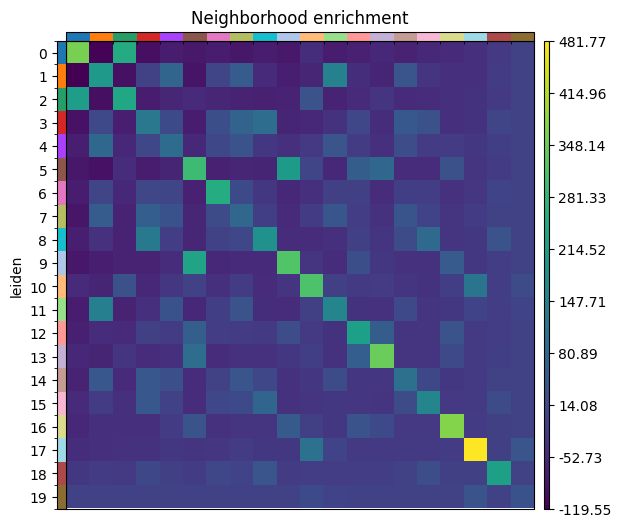

In [7]:
sq.gr.nhood_enrichment(sdata["table"], cluster_key="leiden")
sq.pl.nhood_enrichment(sdata["table"], cluster_key="leiden", figsize=(5, 5))

We can finally visualize the results in spatial coordinates both with squidpy as well as with the novel plotting function in spatialdata.


/mnt/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


CPU times: user 198 ms, sys: 9.51 ms, total: 207 ms
Wall time: 227 ms


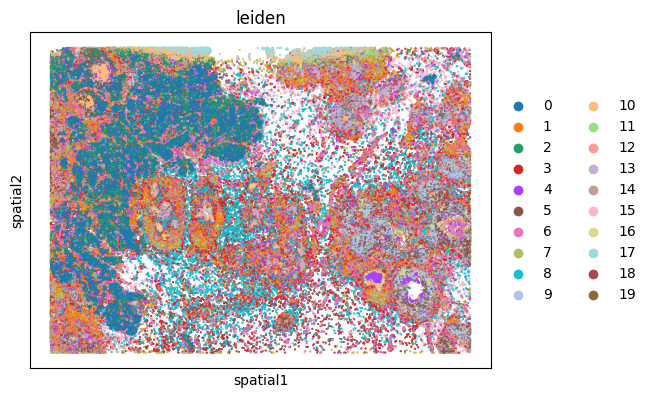

In [8]:
%%time
sq.pl.spatial_scatter(sdata["table"], shape=None, color="leiden")

/mnt/repos/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/repos/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/repos/spatialdata/src/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


/mnt/repos/spatialdata-plot/src/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


CPU times: user 50.3 s, sys: 2.8 s, total: 53.1 s
Wall time: 49.7 s


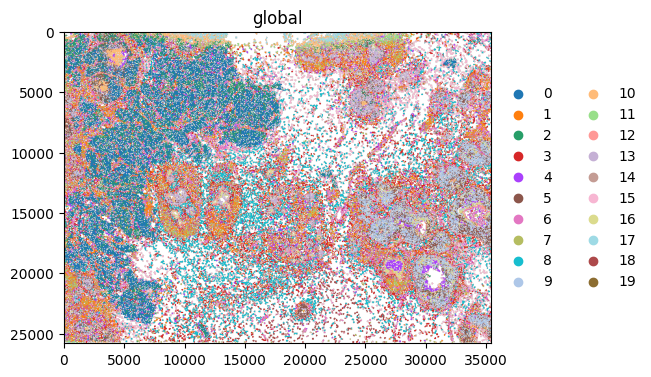

In [9]:
%%time
# currently we need either to use `method='matplotlib`` (which is significantly slower than `method='datashader'`) or we need the one line workaround below because of this bug:
# https://github.com/scverse/spatialdata-plot/issues/291.
sdata["cell_circles"] = sd.transform(sdata["cell_circles"], to_coordinate_system="global")  # workaround
sdata.pl.render_shapes("cell_circles", color="leiden", method="datashader").pl.show(coordinate_systems="global")

## Using the converters from/to the legacy spatial `AnnData` format

We will now show how to convert from/to the legacy spatialdata `AnnData` format. The convertes deal with the complexity of having multiple libraries in the legacy format, and with the generality of coordinate systems in `SpatialData`. For more information please refer to the API documentation of `spatialdata-io`.

In [10]:
from typing import Literal

import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from spatialdata.datasets import blobs_annotating_element
from spatialdata.transformations import Affine, set_transformation
from spatialdata_io.experimental import from_legacy_anndata, to_legacy_anndata

BlobsTypes = Literal["blobs_labels", "blobs_circles", "blobs_polygons", "blobs_multipolygons"]

/mnt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


### Example of conversion from the legacy AnnData to SpatialData

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


/mnt/repos/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `locations` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/repos/spatialdata/src/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053691275..1.1006712].
/mnt/repos/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `locations` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/repos/spatialdata/src/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


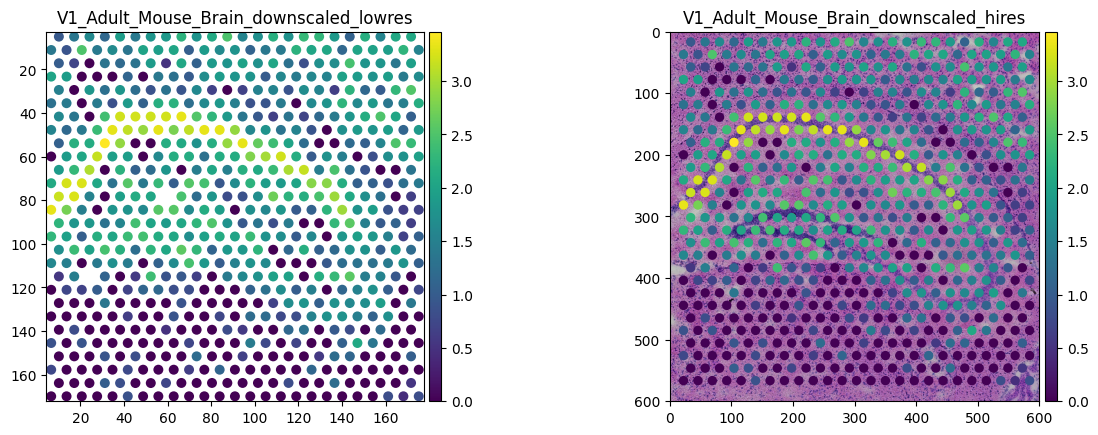

In [11]:
# some datasets you can play around with
# adata = sq.datasets.visium_fluo_adata()
# adata = sq.datasets.merfish()
adata = sq.datasets.visium_hne_adata_crop()

sdata = from_legacy_anndata(adata)

my_gene = "Itpka"
# broken (multiple table not yet supported in spatialdata-plot), this is being fix in https://github.com/scverse/spatialdata-plot/pull/220
sdata.pl.render_images("V1_Adult_Mouse_Brain_hires_image").pl.render_shapes(color=my_gene).pl.show()
plt.show()

### Example of conversion from SpatialData to the legacy AnnData, showing also that affine transformations are handled

/mnt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/mnt/repos/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/mnt/repos/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/tmp/ipykernel_2630528/2475705291.py:13: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


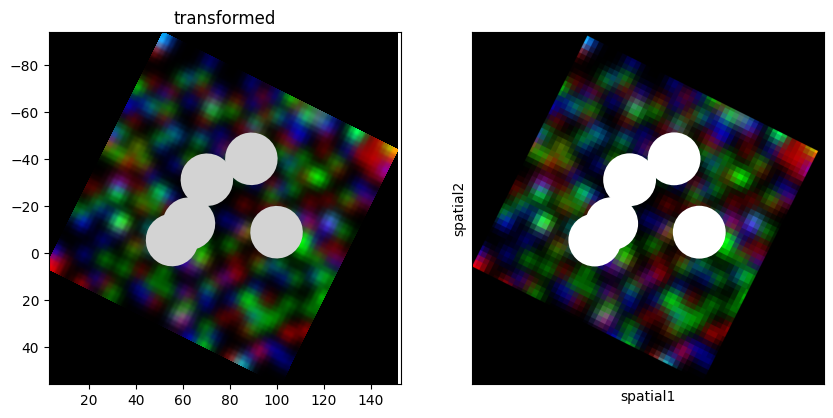

In [12]:
element = "blobs_circles"
sdata = blobs_annotating_element(element)
image = "blobs_multiscale_image"

affine = Affine([[1, 2, 3], [-2, 1, 6], [0, 0, 1]], input_axes=("x", "y"), output_axes=("x", "y"))
set_transformation(sdata[element], affine, "transformed")
set_transformation(sdata[image], affine, "transformed")

adata = to_legacy_anndata(sdata, include_images=True, coordinate_system="transformed")

axes = plt.subplots(1, 2, figsize=(10, 5))[1]
sdata.pl.render_images(image).pl.render_shapes(element).pl.show(coordinate_systems=["transformed"], ax=axes[0])
sc.pl.spatial(
    adata,
    spot_size=300,
    library_id=image,
    img_key="hires",
    na_color="white",
    show=True,
    crop_coord=(0, 2000, 0, 2000),
    ax=axes[1],
)